In [1]:
import matplotlib.pyplot as plt
import cv2

In [3]:
def sd(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])                   

In [92]:
path_image = "E:/test14.jpg"
img1 = cv2.imread(path_image)

In [4]:
path_image = "E:/test13.jpg"
img2 = cv2.imread(path_image)

In [5]:
path_image = "E:/test11.jpg"
img3 = cv2.imread(path_image)

In [6]:
path_image = "E:/test.jpg"
img4 = cv2.imread(path_image)

In [72]:
def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = int(order[-1])

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

In [75]:
def TestVoiting(image):
    # Resize image
    image = cv2.resize(image, (400, 256))

    size = (60, 120)
    step_size = (9, 9)
    downscale = 1.25

    # List to store the detections
    detections = []
    scale = 0
    confidence_score = []
    model = joblib.load('D:/Voiting_model.dat')

    for im_scaled in pyramid_gaussian(image, downscale=downscale):
        # The list contains detections at the current scale
        if im_scaled.shape[0] < size[1] or im_scaled.shape[1] < size[0]:
            break
        print(im_scaled.shape)
        for (x, y, window) in sd(im_scaled, size, step_size):
            if window.shape[0] != size[1] or window.shape[1] != size[0]:
                continue
            window = color.rgb2gray(window)

            fd = hog(window, orientations=9, pixels_per_cell=(8, 8), visualize=False, cells_per_block=(3, 3))
            fd = fd.reshape(1, -1)
            pred = model.predict(fd)
            proba = model.predict_proba(fd)
            confidence = proba[0][1]

            if pred == 1:
                if confidence > 0.5:
                    detections.append((int(x * (downscale ** scale)), int(y * (downscale ** scale)),
                                       confidence,
                                       int(size[0] * (downscale ** scale)),
                                       int(size[1] * (downscale ** scale))))
                confidence_score.append(confidence)
        scale += 1

    # Clone image
    org = image.copy()

    # Bounding boxes
    bounding_boxes = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])

    # Draw parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 1

    # IoU threshold
    threshold = 0.0025

    # Draw bounding boxes and confidence score
    for (start_x, start_y, end_x, end_y), confidence in zip(bounding_boxes, confidence_score):
        (w, h), baseline = cv2.getTextSize(str(confidence), font, font_scale, thickness)
        cv2.rectangle(org, (start_x, start_y - (2 * baseline + 5)), (start_x + w, start_y), (0, 255, 255), -1)
        cv2.rectangle(org, (start_x, start_y), (end_x, end_y), (0, 255, 255), 2)
        cv2.putText(org, str(confidence), (start_x, start_y), font, font_scale, (0, 0, 0), thickness)

    # Run non-max suppression algorithm
    picked_boxes, picked_score = nms(bounding_boxes, confidence_score, threshold)

    # Draw bounding boxes and confidence score after non-maximum suppression
    for (start_x, start_y, end_x, end_y), confidence in zip(picked_boxes, picked_score):
        (w, h), baseline = cv2.getTextSize(str(confidence), font, font_scale, thickness)
        cv2.rectangle(image, (start_x, start_y - (2 * baseline + 5)), (start_x + w, start_y), (0, 255, 255), -1)
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 255, 255), 2)
        cv2.putText(image, str(confidence), (start_x, start_y), font, font_scale, (0, 0, 0), thickness)

    # Convert BGR to RGB for displaying with matplotlib
    org_rgb = cv2.cvtColor(org, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display images
    plt.imshow(image)
    plt.axis('off')
    plt.show()



In [101]:
def TestSVM(image):
    # Resize image
    image = cv2.resize(image, (400, 256))

    size = (64, 128)
    step_size = (9, 9)
    downscale = 1.25

    # List to store the detections
    detections = []
    scale = 0
    confidence_score = []
    model = joblib.load('E:/SVM_model.dat')

    for im_scaled in pyramid_gaussian(image, downscale=downscale):
        # The list contains detections at the current scale
        if im_scaled.shape[0] < size[1] or im_scaled.shape[1] < size[0]:
            break
        for (x, y, window) in sd(im_scaled, size, step_size):
            if window.shape[0] != size[1] or window.shape[1] != size[0]:
                continue
            window = color.rgb2gray(window)

            fd = hog(window, orientations=9, pixels_per_cell=(8, 8), visualize=False, cells_per_block=(2, 2))
            fd = fd.reshape(1, -1)
            pred = model.predict(fd)
            confidence  = model.decision_function(fd)
            if pred == 1:
                if confidence > 0.5:
                    detections.append((int(x * (downscale ** scale)), int(y * (downscale ** scale)),
                                       confidence,
                                       int(size[0] * (downscale ** scale)),
                                       int(size[1] * (downscale ** scale))))
                confidence_score.append(confidence)
        scale += 1

    # Clone image
    org = image.copy()

    # Bounding boxes
    bounding_boxes = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])

    # Draw parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 1

    # IoU threshold
    threshold = 0.4

    # Draw bounding boxes and confidence score
    for (start_x, start_y, end_x, end_y), confidence in zip(bounding_boxes, confidence_score):
        (w, h), baseline = cv2.getTextSize(str(confidence), font, font_scale, thickness)
        # cv2.rectangle(org, (start_x, start_y - (2 * baseline + 5)), (start_x + w, start_y), (0, 255, 255), -1)
        cv2.rectangle(org, (start_x, start_y), (end_x, end_y), (0, 255, 255), 2)
        # cv2.putText(org, str(confidence), (start_x, start_y), font, font_scale, (0, 0, 0), thickness)

    # Run non-max suppression algorithm
    picked_boxes, picked_score = nms(bounding_boxes, confidence_score, threshold)

    # Draw bounding boxes and confidence score after non-maximum suppression
    for (start_x, start_y, end_x, end_y), confidence in zip(picked_boxes, picked_score):
        (w, h), baseline = cv2.getTextSize(str(confidence), font, font_scale, thickness)
        # cv2.rectangle(image, (start_x, start_y - (2 * baseline + 5)), (start_x + w, start_y), (0, 255, 255), -1)
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 255, 255), 2)
        # cv2.putText(image, str(confidence), (start_x, start_y), font, font_scale, (0, 0, 0), thickness)

    # Convert BGR to RGB for displaying with matplotlib
    org_rgb = cv2.cvtColor(org, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display images
    plt.imshow(image)
    plt.axis('off')
    plt.show()



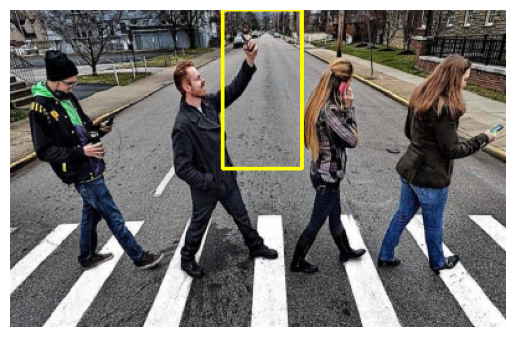

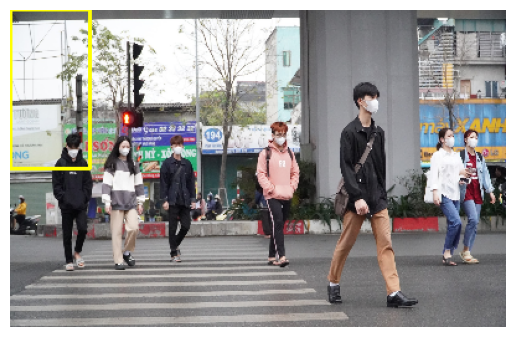

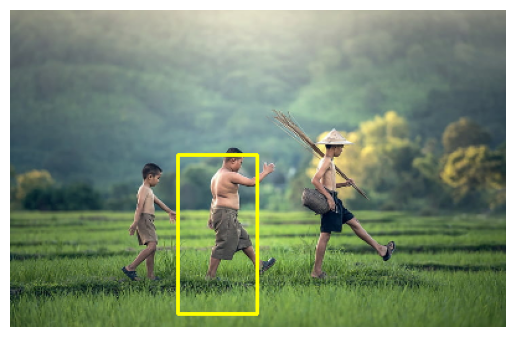

In [102]:
TestSVM(img2)
TestSVM(img3)
TestSVM(img4)

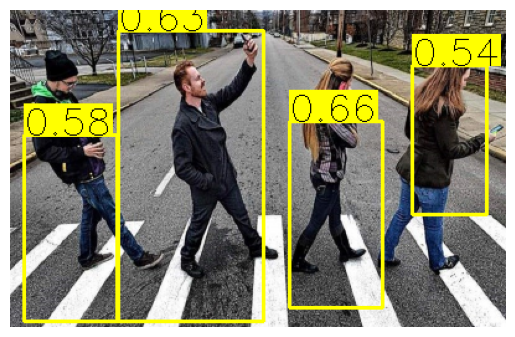

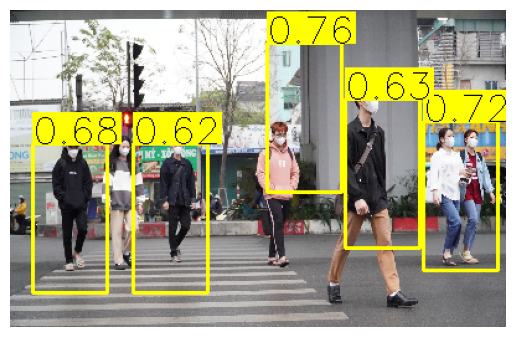

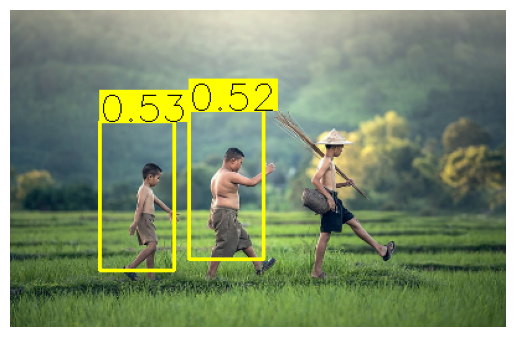

In [94]:
TestVoiting(img2)
TestVoiting(img3)
TestVoiting(img4)